In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
columns = ['datetime','choke','psig','apsig','oil','gas','water']
columns2 = ['choke','psig','apsig','oil','gas','water']

In [3]:
df_raw = pd.read_csv('final.csv')

# use 100 data only
# df_raw = df_raw.head(100)

df_raw = df_raw.set_index('datetime')

In [4]:
df_raw

,choke,psig,apsig,oil,gas,water
datetime,,,,,,
15/5/2021 21:00:00,38,935,320,698.880,4.980,23.616
15/5/2021 21:15:00,38,935,321,822.456,4.988,32.592
15/5/2021 21:30:00,38,940,318,661.368,5.070,26.208
15/5/2021 21:45:00,38,938,317,737.664,5.061,29.232
15/5/2021 22:00:00,38,940,319,661.368,5.078,26.208
...,...,...,...,...,...,...
4/6/2021 08:00:00,42,986,328,771.720,7.638,16.896
4/6/2021 08:15:00,42,984,325,766.032,7.602,16.704
4/6/2021 08:30:00,42,986,328,765.216,7.638,16.704


# normalization min max

In [5]:
# get choke 38 only
df_choke_38 = df_raw[df_raw['choke'] == 38].copy()
df_choke_38.shape

(854, 6)

In [6]:
def normalize_dataframe(df):
    # Create a copy of the input DataFrame to avoid modifying the original
    df_normalized = df.copy()
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column is not a datetime column
        if column != 'datetime':
            # Find the minimum and maximum values in the column
            min_value = df[column].min()
            max_value = df[column].max()
            # Normalize the column values using min-max scaling
            df_normalized[column] = (df[column] - min_value) / (max_value - min_value)
    return df_normalized

def denormalize_dataframe(df_normalized, df_original):
    # Create a copy of the normalized DataFrame to avoid modifying the original
    df_denormalized = df_normalized.copy()
    # Iterate over each column in the DataFrame
    for column in df_normalized.columns:
        # Check if the column is not a datetime column
        if column != 'datetime':
            # Find the minimum and maximum values in the original column
            min_value = df_original[column].min()
            max_value = df_original[column].max()
            # Denormalize the column values using min-max scaling
            df_denormalized[column] = df_normalized[column] * (max_value - min_value) + min_value
    return df_denormalized

In [7]:
# scaler = MinMaxScaler()
# df_choke_38 = df_choke_38.drop(['choke'], axis=1)
# df_choke_38_normalized = scaler.fit_transform(df_choke_38)
# df_choke_38_normalized = pd.DataFrame(df_choke_38_normalized, columns=df_choke_38.columns)
# df_choke_38_normalized['datetime'] = df_choke_38.index
# df_choke_38_normalized = df_choke_38_normalized.set_index('datetime')

df_choke_38 = df_choke_38.drop(['choke'], axis=1)
# df_choke_38_normalized
df_choke_38_normalized = normalize_dataframe(df_choke_38)
df_choke_38_normalized

,psig,apsig,oil,gas,water
datetime,,,,,
15/5/2021 21:00:00,0.431034,0.444444,0.311858,0.128135,0.417431
15/5/2021 21:15:00,0.431034,0.472222,0.748918,0.132497,0.631881
15/5/2021 21:30:00,0.452586,0.388889,0.179187,0.177208,0.479358
15/5/2021 21:45:00,0.443966,0.361111,0.449028,0.172301,0.551606
15/5/2021 22:00:00,0.452586,0.416667,0.179187,0.181570,0.479358
...,...,...,...,...,...
24/5/2021 16:00:00,0.978448,0.833333,0.341397,0.982007,0.220183
24/5/2021 16:15:00,0.987069,0.722222,0.432816,0.966739,0.041284
24/5/2021 16:30:00,0.965517,0.777778,0.464392,0.978190,0.043578


# LSTM Preparation

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_choke_38_normalized.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
# reframed.drop(reframed.columns[[5,6,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.431034   0.444444   0.311858   0.128135   0.417431  0.431034  0.472222   
2   0.431034   0.472222   0.748918   0.132497   0.631881  0.452586  0.388889   
3   0.452586   0.388889   0.179187   0.177208   0.479358  0.443966  0.361111   
4   0.443966   0.361111   0.449028   0.172301   0.551606  0.452586  0.416667   
5   0.452586   0.416667   0.179187   0.181570   0.479358  0.461207  0.416667   

    var3(t)   var4(t)   var5(t)  
1  0.748918  0.132497  0.631881  
2  0.179187  0.177208  0.479358  
3  0.449028  0.172301  0.551606  
4  0.179187  0.181570  0.479358  
5  0.359138  0.181570  0.527523  


# Split Data

In [10]:
train_X = reframed.iloc[:int(len(df_choke_38)*0.8), 0:5].values
test_X = reframed.iloc[int(len(df_choke_38)*0.8):, 0:5].values

train_y = reframed.iloc[:int(len(df_choke_38)*0.8), 5:10].values
test_y = reframed.iloc[int(len(df_choke_38)*0.8):, 5:10].values

print(train_y)

[[0.43103448 0.4722222  0.74891776 0.13249728 0.63188076]
 [0.4525862  0.3888889  0.17918682 0.17720829 0.4793578 ]
 [0.44396552 0.3611111  0.4490281  0.17230098 0.5516055 ]
 ...
 [0.9439655  0.6388889  0.49605298 0.8876772  0.04587156]
 [0.9396552  0.6388889  0.3934301  0.90348965 0.0946101 ]
 [0.9439655  0.6944444  0.45115015 0.91439474 0.13876146]]


# LSTM Model

In [11]:
# # sigmoid
# def sigmoid(x):
#     return 1 / (1 + math.exp(-x))
# # sigmoid derivative
# def sigmoid_derivative(x):
#     return x * (1 - x)
# # tanh
# def tanh(x):
#     return math.tanh(x)
# # tanh derivative
# def tanh_derivative(x):
#     return 1.0 - x**2

In [12]:
# # create simple LSTM cell no function and class
# def simple_lstm_cell(inputs, h, c, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
#     """
#     Implements a simple LSTM cell.

#     Args:
#         inputs (ndarray): Input array of shape (batch_size, input_size).
#         h (ndarray): Hidden state array of shape (batch_size, hidden_size).
#         c (ndarray): Cell state array of shape (batch_size, hidden_size).
#         Wf (ndarray): Weight matrix for the forget gate of shape (input_size, hidden_size).
#         Wi (ndarray): Weight matrix for the input gate of shape (input_size, hidden_size).
#         Wc (ndarray): Weight matrix for the cell state of shape (input_size, hidden_size).
#         Wo (ndarray): Weight matrix for the output gate of shape (input_size, hidden_size).
#         bf (ndarray): Bias vector for the forget gate of shape (hidden_size,).
#         bi (ndarray): Bias vector for the input gate of shape (hidden_size,).
#         bc (ndarray): Bias vector for the cell state of shape (hidden_size,).
#         bo (ndarray): Bias vector for the output gate of shape (hidden_size,).

#     Returns:
#         tuple: A tuple containing the updated hidden state (h) and cell state (c) arrays.
#     """

#     f = sigmoid(np.dot(inputs, Wf) + np.dot(h, bf))
#     i = sigmoid(np.dot(inputs, Wi) + np.dot(h, bi))
#     c_tilda = tanh(np.dot(inputs, Wc) + np.dot(h, bc))
#     c = f * c + i * c_tilda
#     o = sigmoid(np.dot(inputs, Wo) + np.dot(h, bo))
#     h = o * tanh(c)
#     return h, c, o

In [13]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases for the LSTM cell
        # self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bf = np.random.randn(hidden_size, 1)
        self.Wf = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bf = np.zeros((hidden_size, 1))

        # self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bi = np.random.randn(hidden_size, 1)
        self.Wi = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bi = np.zeros((hidden_size, 1))

        # self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bc = np.random.randn(hidden_size, 1)
        self.Wc = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bc = np.zeros((hidden_size, 1))

        # self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bo = np.random.randn(hidden_size, 1)
        self.Wo = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bo = np.zeros((hidden_size, 1))

        # Initialize weights for the output layer
        self.Wy = np.random.randn(output_size, hidden_size)
        self.by = np.random.randn(output_size, 1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, x, h_prev, C_prev):
      assert h_prev.shape == (self.hidden_size, 1)
      assert x.shape == (self.input_size, 1)
      assert C_prev.shape == (self.hidden_size, 1)

      # Concatenate hidden state and input
      combined = np.concatenate((h_prev, x), axis=0)

      # Forget gate
      ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)

      # Input gate
      it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
      Ct_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)

      # Cell state
      Ct = ft * C_prev + it * Ct_hat

      # Output gate
      ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
      ht = ot * self.tanh(Ct)

      # Compute output
      yt = np.dot(self.Wy, ht) + self.by

      assert yt.shape == (self.output_size, 1)
      assert ht.shape == (self.hidden_size, 1)
      assert Ct.shape == (self.hidden_size, 1)

      return yt, ht, Ct

    def train(self, X, Y, epochs=1000, learning_rate=0.001):
        m, n_x = X.shape
        n_y, _ = Y.shape

        # Initialize hidden state and cell state
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        for epoch in range(epochs):
            loss = 0
            for t in range(m):
                x = X[t].reshape(-1, 1)
                y_true = Y[t].reshape(-1, 1)

                # Forward pass
                y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)
                self.h_prev = h_prev
                self.C_prev = C_prev

                ## Compute gradients
                dy = y_pred - y_true

                # Compute gradients for output layer
                dWy = np.dot(dy, h_prev.T)
                dby = dy

                # Compute gradients for LSTM cell
                dh = np.dot(self.Wy.T, dy)
                dC = dh * self.tanh(C_prev) * (1 - self.tanh(C_prev))

                # Compute gradients for output gate
                do = dh * self.tanh(C_prev)
                dWo = np.dot(do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo)), np.concatenate((h_prev, x), axis=0).T)
                dbo = do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo))

                # Compute gradients for cell gate
                dC_bar = dC * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)
                dWc = np.dot(dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2), np.concatenate((h_prev, x), axis=0).T)
                dbc = dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2)

                # Compute gradients for input gate
                di = dC * self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc)
                dWi = np.dot(di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)), np.concatenate((h_prev, x), axis=0).T)
                dbi = di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi))

                # Compute gradients for forget gate
                df = dC * C_prev
                dWf = np.dot(df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf)), np.concatenate((h_prev, x), axis=0).T)
                dbf = df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf))

                # Update weights and biases
                self.Wy -= learning_rate * dWy
                self.by -= learning_rate * dby
                self.Wo -= learning_rate * dWo
                self.bo -= learning_rate * dbo
                self.Wc -= learning_rate * dWc
                self.bc -= learning_rate * dbc
                self.Wi -= learning_rate * dWi
                self.bi -= learning_rate * dbi
                self.Wf -= learning_rate * dWf
                self.bf -= learning_rate * dbf

                # Compute loss (mean squared error)
                loss += np.sum((y_true - y_pred) ** 2) / 2
            
            printer = f'Epoch {epoch + 1}/{epochs}, Loss: {loss / m}'
            print(printer, end='\r')

    def predict(self, X):
        m, n_x = X.shape
        predictions = np.zeros((m, self.output_size))

        # Initialize hidden state and cell state
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        for t in range(m):
            x = X[t].reshape(-1, 1)

            # Forward pass
            y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)

            # Store prediction
            predictions[t] = y_pred.flatten()

        return predictions

    def evaluate(self, X, Y):
        predictions = self.predict(X)
        mse = np.mean((Y - predictions) ** 2)
        rmse = np.sqrt(mse)
        return mse, rmse

In [14]:
# # Example usage
# np.random.seed(0)
# X = np.random.rand(100, 5)
# Y = np.random.rand(100, 5)

lstm = LSTM(input_size=5, hidden_size=100, output_size=5)
lstm.train(train_X, train_y, epochs=1000)

In [15]:
predictions = lstm.predict(test_X)
print(predictions[:5])

mse, rmse = lstm.evaluate(test_X, test_y)
print(f'MSE: {mse}, RMSE: {rmse}')

[[0.96536718 0.69646455 0.49104284 0.90279183 0.12992753]
 [0.96585729 0.70517325 0.48325651 0.90883141 0.10489644]
 [0.96337952 0.70726983 0.4808609  0.91329003 0.08118641]
 [0.96278168 0.69485874 0.49963647 0.91679228 0.06101456]
 [0.97043592 0.69321948 0.52162642 0.91443843 0.0499664 ]]
MSE: 0.0023082794372492987, RMSE: 0.048044556791059054


In [16]:
# denormalize
# predictions = scaler.inverse_transform(predictions)
# test_y = scaler.inverse_transform(test_y)

predictions = denormalize_dataframe(pd.DataFrame(predictions, columns=df_choke_38.columns), df_choke_38)
test_y = denormalize_dataframe(pd.DataFrame(test_y, columns=df_choke_38.columns), df_choke_38)
train_X = denormalize_dataframe(pd.DataFrame(train_X, columns=df_choke_38.columns), df_choke_38)

print(predictions[:5])
print(test_y[:5])
print(train_X[:5])

          psig       apsig         oil       gas      water
0  1058.965185  329.072724  749.543417  6.400720  11.582247
1  1059.078890  329.386237  747.341879  6.411797  10.534546
2  1058.504048  329.461714  746.664533  6.419974   9.542138
3  1058.365350  329.014915  751.973214  6.426397   8.697825
4  1060.141134  328.955901  758.190741  6.422080   8.235394
     psig  apsig         oil    gas     water
0  1054.0  329.0  731.591980  6.422  9.455999
1  1053.0  329.0  733.079956  6.422  7.872000
2  1053.0  328.0  751.703979  6.412  7.248000
3  1055.0  328.0  761.423950  6.412  6.528000
4  1055.0  329.0  743.519958  6.393  6.384000
    psig  apsig         oil    gas      water
0  935.0  320.0  698.880005  4.980  23.616001
1  935.0  321.0  822.455994  4.988  32.591999
2  940.0  318.0  661.367981  5.070  26.208000
3  938.0  317.0  737.664001  5.061  29.231998
4  940.0  319.0  661.367981  5.078  26.208000


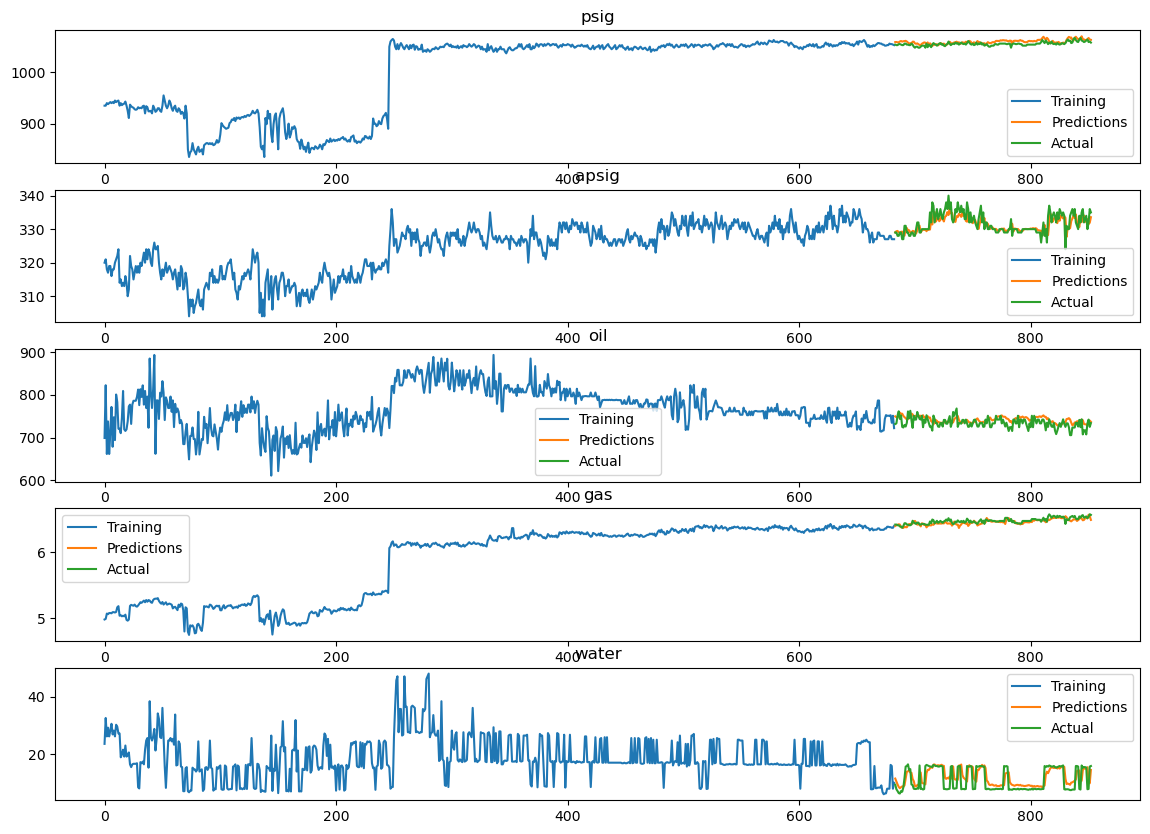

In [17]:
# create plot the predictions and actual comparison
fix, axs = plt.subplots(figsize=(14, 10), nrows=5)

for i, ax in enumerate(axs):
    ax.plot(list(range(0, train_X.shape[0])), train_X.iloc[:,i], label='Training')
    ax.plot(list(range(train_X.shape[0], train_X.shape[0] + predictions.shape[0])), predictions.iloc[:,i], label='Predictions')
    ax.plot(list(range(train_X.shape[0], train_X.shape[0] + test_y.shape[0])), test_y.iloc[:,i], label='Actual')
    ax.set_title(df_choke_38_normalized.columns[i])
    ax.legend()

plt.show()